# Notebook to match VASCA sources to SIMBAD database sources positionally
Set your option in the cell bellow

In [1]:
region_name = "ALL_10-800" #"CAINGSGII_10-800" #"TDS" #"CAINGSGII_10-800" #"WD" #"MDIS_10-800" #"TDS" #  _ELAISN1
region_dir_name = "./vasca_pipeline/"+region_name+"/"
region_cat_fname = region_dir_name+"region_"+region_name+"_cat.fits"

In [2]:
%matplotlib widget
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
from vasca.region import Region
import vasca.visualization as vvis
from vasca.utils import otype2ogroup,dd_ogrp2otypes, dd_ogrp2col, get_col_cycler,add_ogrp, color_palette, nb_fig
from astropy import units as uu

from loguru import logger
logger.enable("vasca")

# Get region
rc = Region()
rc.load_from_fits(region_cat_fname)

# Get SIMBAD object type info
tt_nodes = Table.read("./resources/SIMBAD_otypes/otypes_nodes.csv")
tt_nodes.rename_column("Id", "otype")
add_ogrp(tt_nodes)

2024-01-03 15:26:23.702 | DEBUG    | vasca.tables:load_from_fits:328 - Loading file with name './vasca_pipeline/ALL_10-800/region_ALL_10-800_cat.fits'
2024-01-03 15:26:23.711 | DEBUG    | vasca.tables:load_from_fits:339 - Loading table 'tt_fields'
2024-01-03 15:26:23.722 | DEBUG    | vasca.tables:load_from_fits:339 - Loading table 'tt_filters'
2024-01-03 15:26:23.728 | DEBUG    | vasca.tables:load_from_fits:339 - Loading table 'tt_visits'
2024-01-03 15:26:23.738 | DEBUG    | vasca.tables:load_from_fits:339 - Loading table 'tt_sources'
2024-01-03 15:26:23.763 | DEBUG    | vasca.tables:load_from_fits:339 - Loading table 'tt_detections'
2024-01-03 15:26:23.794 | DEBUG    | vasca.tables:load_from_fits:339 - Loading table 'tt_coadd_detections'
2024-01-03 15:26:23.896 | DEBUG    | vasca.tables:load_from_fits:339 - Loading table 'tt_coadd_sources'
2024-01-03 15:26:23.946 | DEBUG    | vasca.tables:load_from_fits:339 - Loading table 'tt_src_id_map'
2024-01-03 15:26:23.965 | DEBUG    | vasca.tab

### Prepare association data for plotting

In [3]:
#Add Object group to source table
rc.copy_table_columns("tt_sources","tt_simbad",["otype","ogrp","match_distance"],"simbad_match_id")
rc.tt_sources.rename_column("match_distance","match_distance_simbad")
rc.tt_sources.rename_column("ogrp","ogrp_simbad")
sel_simbad = rc.tt_sources["sel"].data
print(f"Number of SIMBAD matches is: {sel_simbad.sum()}  ({100* sel_simbad.sum() / len(rc.tt_sources)} )%")

rc.copy_table_columns("tt_sources","tt_gaiadr3",["PQSO", "PGal", "PSS","match_distance","Gmag_abs","BP-RP", "ogrp"],"gaiadr3_match_id")
rc.tt_sources.rename_column("match_distance","match_distance_gaiadr3")
rc.tt_sources.rename_column("ogrp","ogrp_gaiadr3")
sel_gaiadr3 = rc.tt_sources["sel"].data
print(f"Number of GAIA matches is: {sel_gaiadr3.sum()}  ({100*sel_gaiadr3.sum() / len(rc.tt_sources)} )%")

sel_match = np.array(sel_simbad+sel_gaiadr3, dtype=bool)
print(f"Total number of matches is: {sel_match.sum()}  ({100*sel_match.sum() / len(rc.tt_sources)} )%")

#Copy lomb scargle result into tt_sources
rc.copy_table_columns("tt_sources","tt_lombscargle",["ls_peak_pval", "ls_model_rchiq"],"rg_src_id")


2024-01-03 15:26:24.209 | DEBUG    | vasca.tables:copy_table_columns:1122 - Copying columns ['otype', 'ogrp', 'match_distance'] from table tt_simbad to tt_sources matching simbad_match_id 
2024-01-03 15:26:24.559 | DEBUG    | vasca.tables:copy_table_columns:1122 - Copying columns ['PQSO', 'PGal', 'PSS', 'match_distance', 'Gmag_abs', 'BP-RP', 'ogrp'] from table tt_gaiadr3 to tt_sources matching gaiadr3_match_id 


Number of SIMBAD matches is: 4202  (100.0 )%


2024-01-03 15:26:24.992 | DEBUG    | vasca.tables:copy_table_columns:1122 - Copying columns ['ls_peak_pval', 'ls_model_rchiq'] from table tt_lombscargle to tt_sources matching rg_src_id 


Number of GAIA matches is: 4202  (100.0 )%
Total number of matches is: 4202  (100.0 )%


In [4]:
display(rc.tt_sources[rc.tt_sources["rg_src_id"]==167210])
display(rc.tt_simbad[rc.tt_simbad["rg_src_id"]==167210])

fd_src_id,nr_det,ra,dec,pos_err,pos_xv,pos_var,pos_cpval,pos_rchiq,coadd_src_id,coadd_dist,obs_filter_id,sel,flux,flux_err,flux_nxv,flux_var,flux_cpval,flux_rchiq,coadd_ffactor,coadd_fdiff_s2n,rg_fd_id,rg_src_id,nr_fd_srcs,hr,hr_err,maincat_match_id,simbad_match_id,gaiadr3_match_id,gfcat_src_id,gfcat_dist,flux_ne,otype,ogrp_simbad,match_distance_simbad,PQSO,PGal,PSS,match_distance_gaiadr3,Gmag_abs,BP-RP,ogrp_gaiadr3,ls_peak_pval,ls_model_rchiq
,,deg,deg,arcsec,arcsec2,arcsec2,,,,arcsec,,,1e-06 Jy,1e-06 Jy,,1e-12 Jy2,,,,,,,,,,,,,,arcsec,,,,arcsec,,,,arcsec,,,,,
int32,int32[2],float64,float64,float32,float32,float32,float32,float32,int64,float32,int32[2],bool,float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],int64,int32,int32,float32,float32,int32,int32,int32,int64,float32,float32[2],bytes32,bytes8,float32,float32,float32,float32,float32,float32,float32,bytes8,float32,float32
-1,4 .. 4,214.62440598562964,53.72528505213003,0.27493268,0.022740893,0.664338,0.19703148,0.9517289,536974,0.20271283,1 .. 2,True,7.4602203 .. 5.308157,0.32909235 .. 0.4324838,0.46987018 .. -0.014302821,26.592062 .. 0.3573625,1.0274218e-33 .. 0.7358296,52.176945 .. 0.42394805,-100.0 .. 1.0048621,-10000.0 .. 0.043493073,-1,167210,2,0.8962923,0.21604146,-1,1153,-1,-1,-1.0,0.68547076 .. --,SN*,GAL,0.8072534,-1.0,-1.0,-1.0,-1.0,-100.0,-1.0,none,-1.0,-1.0


main_id,ra,dec,ra_prec,dec_prec,coo_err_maja,coo_err_mina,coo_err_angle,coo_qual,coo_wavelength,coo_bibcode,otype,otypes,distance_distance,distance_q,distance_unit,distance_merr,distance_perr,distance_method,distance_bibcode,match_distance,rvz_type,rvz_radvel,rvz_error,rvz_qual,rvz_wavelength,rvz_bibcode,z_value,sp_type,sp_qual,sp_bibcode,script_number_id,rg_src_id,simbad_match_id,ogrp
,deg,deg,,,mas,mas,deg,,,,,,,,,,,,,arcsec,,km / s,km / s,,,,,,,,,,,
bytes32,float64,float64,int16,int16,float32,float32,int16,bytes1,bytes1,bytes32,bytes32,bytes32,float64,bytes1,bytes4,float64,float64,bytes8,bytes19,float32,bytes1,float64,float32,bytes1,bytes1,bytes32,float64,bytes32,bytes32,bytes32,int32,int32,int32,bytes8
PS1-11pf,214.62428333333332,53.725497222222224,7,7,--,--,0,C,O,2015ApJ...799..208S,SN*,SN*,--,--,--,--,--,--,--,0.8073,z,0.148,--,D,O,2015ApJ...799..208S,0.1480000,SNIIP,C,2015ApJ...799..208S,1588,167210,1153,GAL


### Plot found object types

Skipping otype none


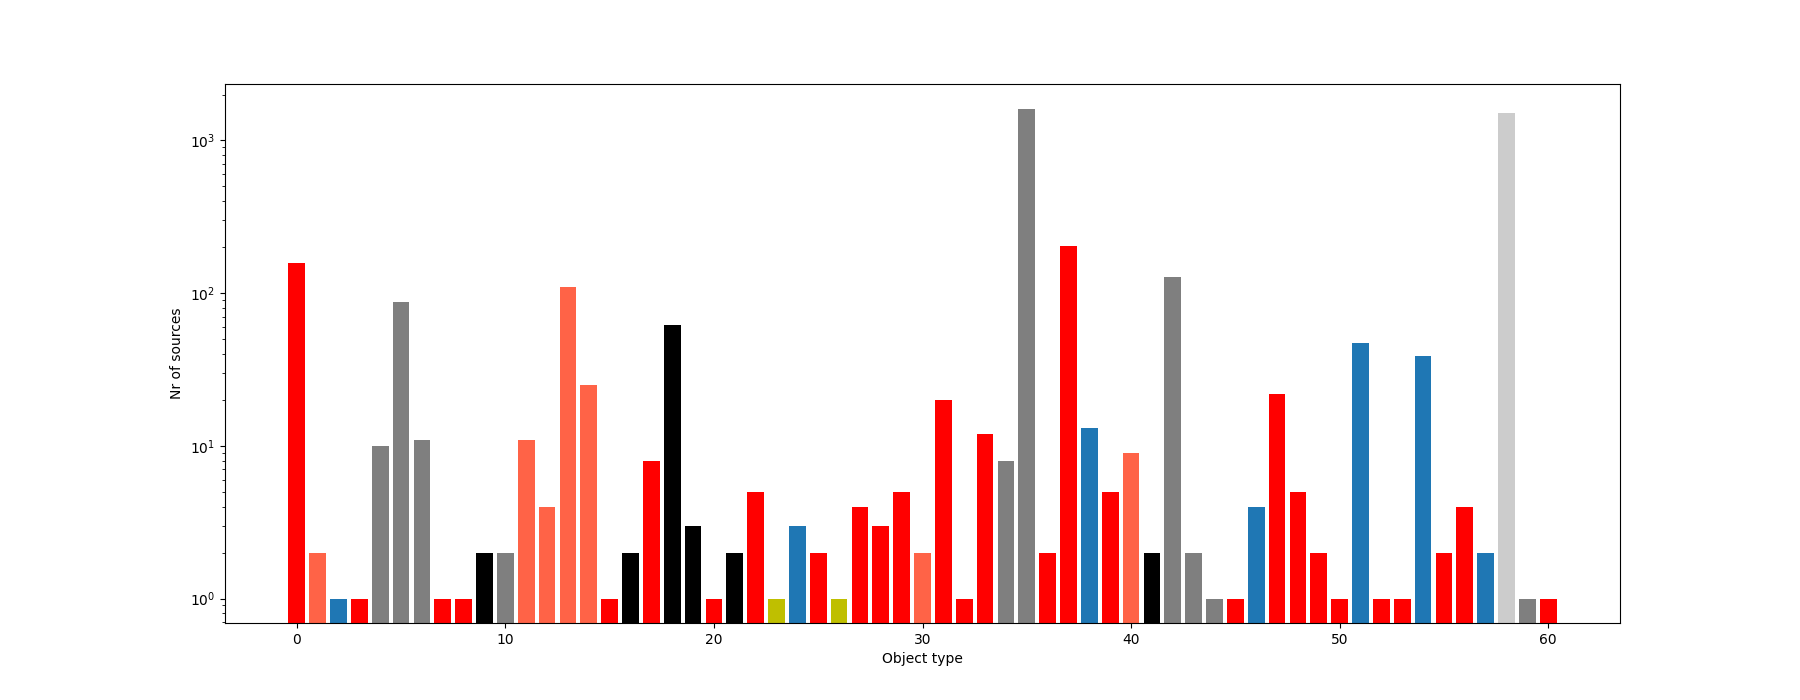

otype   ogrp              Description                  Label      sure nr_srcs
----- ------- ------------------------------------ ------------- ----- -------
  AG?     AGN                Active Galaxy Nucleus           AGN False      10
  AGN     AGN                Active Galaxy Nucleus           AGN  True      87
  BLL     AGN                               BL Lac         BLLac  True      11
  Bla     AGN                               Blazar        Blazar  True       2
   Q?     AGN                               Quasar           QSO False       8
  QSO     AGN                               Quasar           QSO  True    1620
  Sy1     AGN                     Seyfert 1 Galaxy      Seyfert1  True     127
  Sy2     AGN                     Seyfert 2 Galaxy      Seyfert2  True       2
  SyG     AGN                       Seyfert Galaxy       Seyfert  True       1
   rG     AGN                         Radio Galaxy        RadioG  True       1
   ** Binary*              Double or Multiple Star  

In [5]:
#Prepare data
sel_mt = rc.tt_sources["sel"]
otypes_all, otype_cts_all= np.unique(rc.tt_sources[sel_mt]["otype"],return_counts=True)
dd_otype2id = dict(zip(list(otypes_all),range(len(otypes_all))))

#Prepare table to plot pycharts
onames = ["otype", "ogrp","Description","Label", "sure", "nr_srcs"]
odtypes = ["S8"  ,"S8"   , "S128"        ,"S8"  , bool, np.int32  ]
tt_otypes = Table(names=onames, dtype=odtypes)

#Do bar chart of all otypes color coded by ogrp
fig_otypes = plt.figure("Source types",figsize=(18, 7), clear=True)
fig_otypes.clf()
tt_mt_grp =  rc.tt_sources[sel_mt].group_by("ogrp_simbad")
sel_nodes = np.zeros(len(tt_nodes), dtype=bool)
for group, tt_grp in zip(tt_mt_grp.groups.keys, tt_mt_grp.groups):
    otypes, otype_cts= np.unique(tt_grp["otype"],return_counts=True)
    otypes_id = []
    for ii in range(len(otypes)):
        otype = otypes[ii]
        otype_ct = otype_cts[ii]
        otypes_id.append(dd_otype2id[otype])
        sure = True 
        sel_node = tt_nodes["otype"]==otype
        if sel_node.sum()!=1:
            sel_node = tt_nodes["Candidate"]==otype
            sure = False
        if sel_node.sum()!=1:
            print("Skipping otype",otype)
            continue
        tt_row = tt_nodes[sel_node]
        ll_row = [otype,tt_row["ogrp"].data[0].decode('UTF-8'),tt_row["Description"].data[0],tt_row["Label"].data[0],sure,otype_ct]
        tt_otypes.add_row(ll_row)
        sel_nodes += sel_node
    plt.bar( otypes_id, otype_cts, align='center', label=group[0], color = dd_ogrp2col[group[0]])
plt.yscale('log')
#plt.grid()
plt.xlabel("Object type")
plt.ylabel("Nr of sources")
plt.show()
plt.legend()
_ = plt.xticks(range(len(otypes_all)), otypes_all, size='small')

#Printout otypes whch have no ogrp assigned yet
sel_ogrp_none = rc.tt_simbad["ogrp"]=="none"
if sel_ogrp_none.sum()>0:
    print("Unclassified new otypes:")
    display(rc.tt_simbad["main_id","otype","rg_src_id"][sel_ogrp_none])

#tt_nodes["otype","Candidate","Description","ogrp","Label","Category","Subcategory"][sel_nodes].pprint_all()
tt_otypes.pprint_all()

  ogrp  otype             Description              nr_srcs
------- ----- ------------------------------------ -------
    AGN   AGN                Active Galaxy Nucleus      87
    AGN   BLL                               BL Lac      11
    AGN   Bla                               Blazar       2
    AGN   QSO                               Quasar    1620
    AGN   Sy1                     Seyfert 1 Galaxy     127
    AGN   Sy2                     Seyfert 2 Galaxy       2
    AGN   SyG                       Seyfert Galaxy       1
    AGN    rG                         Radio Galaxy       1
Binary*    **              Double or Multiple Star       2
Binary*   CV*                   Cataclysmic Binary      11
Binary*   EB*                     Eclipsing Binary     109
Binary*   No*                       Classical Nova       2
Binary*   SB*                 Spectroscopic Binary       9
    GAL   BiC  Brightest Galaxy in a Cluster (BCG)       2
    GAL   EmG                 Emission-line galaxy      

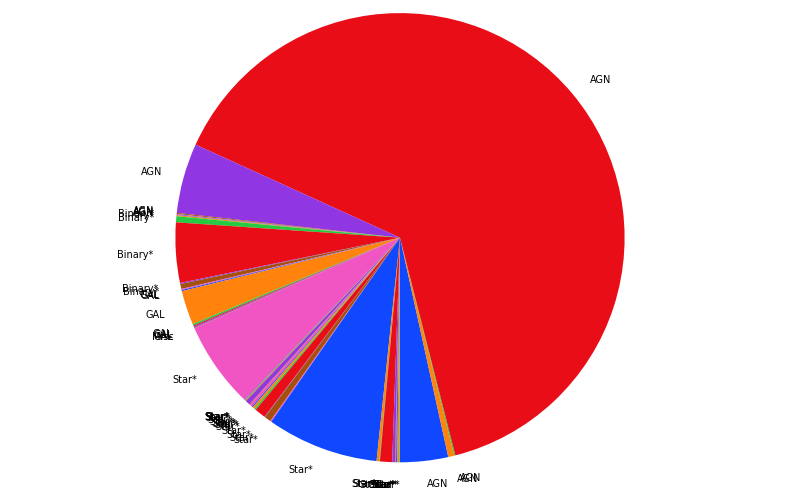

In [6]:
# Pie chart showing fractions of grouped classification
tt_otypes["sure"][tt_otypes["ogrp"]=="UNK"]=False
tt_osure = tt_otypes[tt_otypes["sure"]==True]["ogrp","otype","Description","nr_srcs"]
tt_osure.pprint_all()
tt_osure.write(region_dir_name+"SIMBAD_otypes.tex", format='latex',overwrite=True)

# Grouped classifications
sel_mt = rc.tt_sources["sel"]
plabel, pvals = np.unique(rc.tt_sources[sel_mt]["ogrp_simbad"],return_counts=True)
percent = [i/pvals.sum()*100 for i in pvals]

# Figure (notebook-optimized)
fig, ax = nb_fig(num="class pie", gr_size=8, layout="constrained", clear=True)

# Seaborn colors
alpha = 0.95
c_bright_rgb = color_palette(name="bright", n=len(plabel), show_in_notebook=False)
c_bright_rgba = [(*c[:3], alpha) for c in c_bright_rgb]

# Chart
patches, text = ax.pie(tt_osure["nr_srcs"],
					   labels=tt_osure["ogrp"],
					   colors=c_bright_rgba,
					   startangle=270,
					   radius=1.2,
					   textprops={'fontsize': 7}
					  )

# # External legend, sorted by percentage
# xlabels = [f'{i} - {j:d} ({k:1.1f}%)' for i,j,k in zip(plabel, pvals, percent)]
# sort_legend = True
# if sort_legend:
#     patches, labels, _ =  zip(
#         *sorted(
#             zip(patches, xlabels, pvals),
#             key=lambda x: x[2],
#             reverse=True
#         )
#     )
# _=ax.legend(
#     patches,
#     labels,
#     loc='best',
#     bbox_to_anchor=(-0.1, 1.),
#     fontsize=10,
#     title=f"Number of cross-matched\nVASCA sources (total: {pvals.sum()})",
#     title_fontsize=12,
#     alignment='left',
# )

### Scatter plots of source variables by group

2024-01-03 15:26:25.892 | DEBUG    | vasca.visualization:plot_table_scatter:545 - Plotting of variables 'flux_nxv' and 'flux'
2024-01-03 15:26:25.912 | DEBUG    | vasca.visualization:plot_table_scatter:545 - Plotting of variables 'flux_nxv' and 'hr'
2024-01-03 15:26:25.928 | DEBUG    | vasca.visualization:plot_table_scatter:545 - Plotting of variables 'flux_nxv' and 'flux'
2024-01-03 15:26:25.940 | DEBUG    | vasca.visualization:plot_table_scatter:545 - Plotting of variables 'flux_nxv' and 'hr'
2024-01-03 15:26:25.970 | DEBUG    | vasca.visualization:plot_table_scatter:545 - Plotting of variables 'flux_nxv' and 'flux'
2024-01-03 15:26:25.998 | DEBUG    | vasca.visualization:plot_table_scatter:545 - Plotting of variables 'flux_nxv' and 'hr'
2024-01-03 15:26:26.030 | DEBUG    | vasca.visualization:plot_table_scatter:545 - Plotting of variables 'flux_nxv' and 'flux'
2024-01-03 15:26:26.054 | DEBUG    | vasca.visualization:plot_table_scatter:545 - Plotting of variables 'flux_nxv' and 'hr'


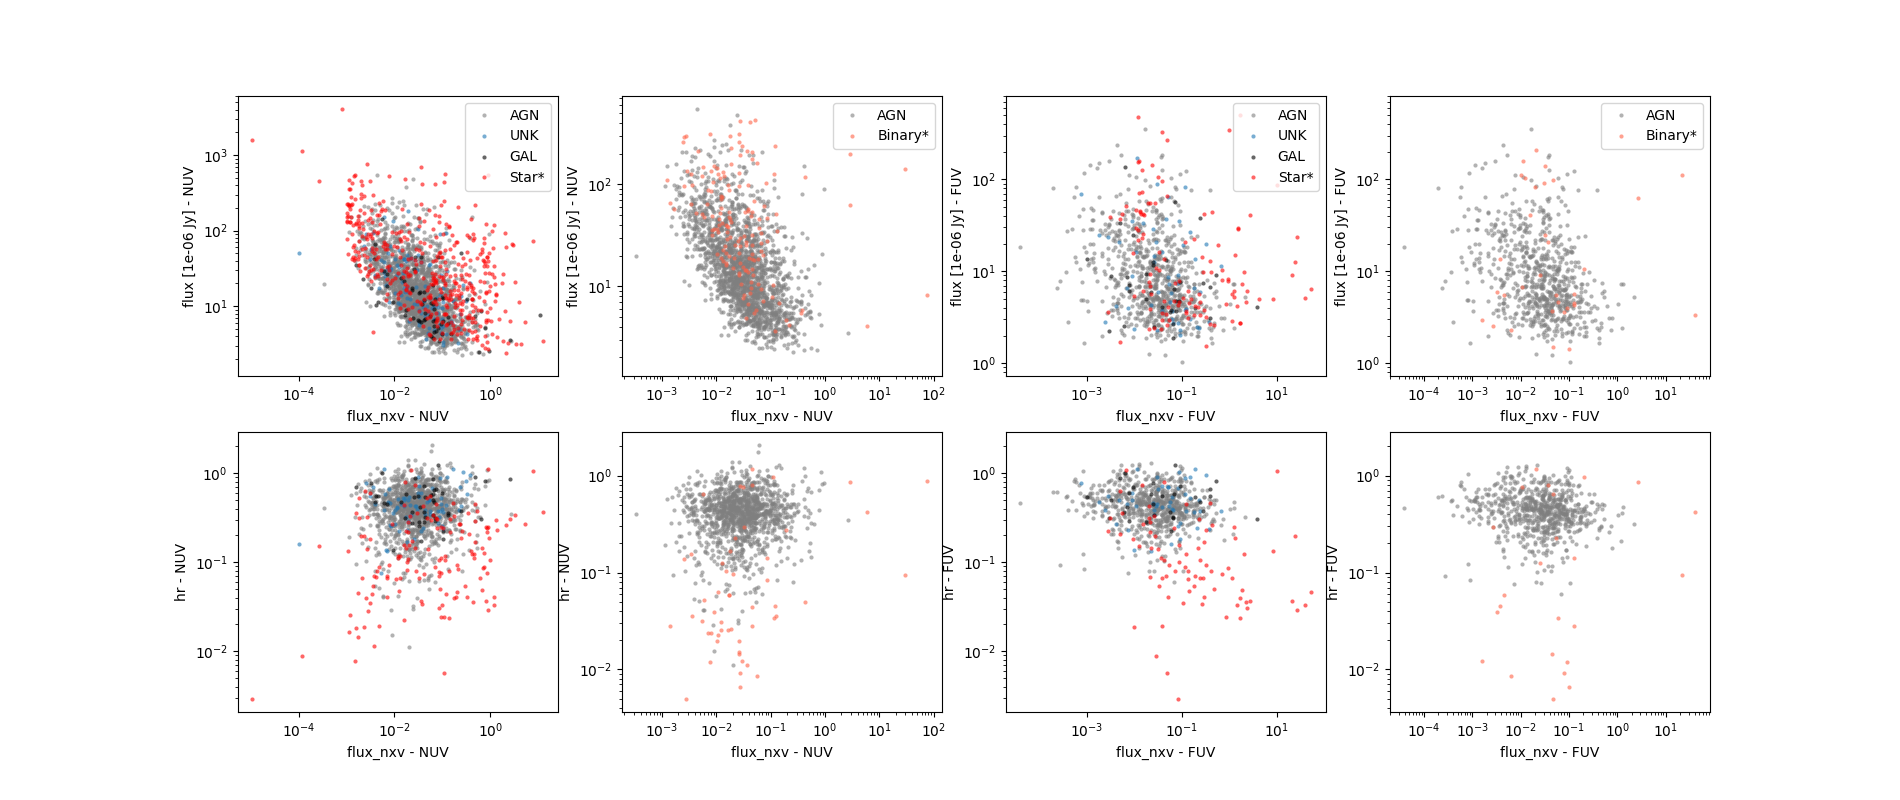

In [7]:
plot_kwargs = {"markersize": 3.0,"alpha":0.6}
fig, axs = plt.subplots(2, 4, figsize=(19, 8))
#fig.clf()
axs = axs.flatten()
plt_ogrops = [["AGN","UNK","GAL",'Star*'],["AGN", 'Binary*']]

plt_flts = [1,2]
ctr = 0
for flt in plt_flts:
    for ogrps in plt_ogrops:
        axs[ctr].set_prop_cycle(get_col_cycler(ogrps))
        vvis.plot_table_scatter(rc.tt_sources,"flux_nxv", "flux", ax=axs[ctr], xscale="log",yscale="log", obs_filter_id=flt, grp_var="ogrp_simbad",grp_vals = ogrps,**plot_kwargs)

        axs[ctr+4].set_prop_cycle(get_col_cycler(ogrps))
        vvis.plot_table_scatter(rc.tt_sources,"flux_nxv", "hr", ax=axs[ctr+4], xscale="log",yscale="log", obs_filter_id=flt, grp_var="ogrp_simbad",grp_vals = ogrps,**plot_kwargs)
        ctr +=1

_ = axs[0].legend()
_ = axs[1].legend()
_ = axs[2].legend()
_ = axs[3].legend()
#print(dd_ogrp2otypes.keys())r

### Compare object classification from SIMBAD to the one from GAIA-DR3

2024-01-03 15:26:26.808 | DEBUG    | vasca.visualization:plot_table_hist:447 - Plotting histogram of variable 'PQSO'
/home/buehler/miniforge3/envs/vas/lib/python3.10/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
2024-01-03 15:26:26.828 | DEBUG    | vasca.visualization:plot_table_hist:447 - Plotting histogram of variable 'PQSO'
2024-01-03 15:26:26.873 | DEBUG    | vasca.visualization:plot_table_hist:447 - Plotting histogram of variable 'PQSO'
2024-01-03 15:26:26.936 | DEBUG    | vasca.visualization:plot_table_hist:447 - Plotting histogram of variable 'PSS'
2024-01-03 15:26:26.979 | DEBUG    | vasca.visualization:plot_table_hist:447 - Plotting histogram of variable 'PSS'
2024-01-03 15:26:27.005 | DEBUG    | vasca.visualization:plot_table_hist:447 - Plotting histogram of variable 'PSS'
2024-01-03 15:26:27.026 | DEBUG    | vasca.visualization:plot_table_hist:447 - Plotting histogram of variable 'PGal'
2024-01

SIMBAD assoc: orange:AGN; red:Star; brown:Galaxy


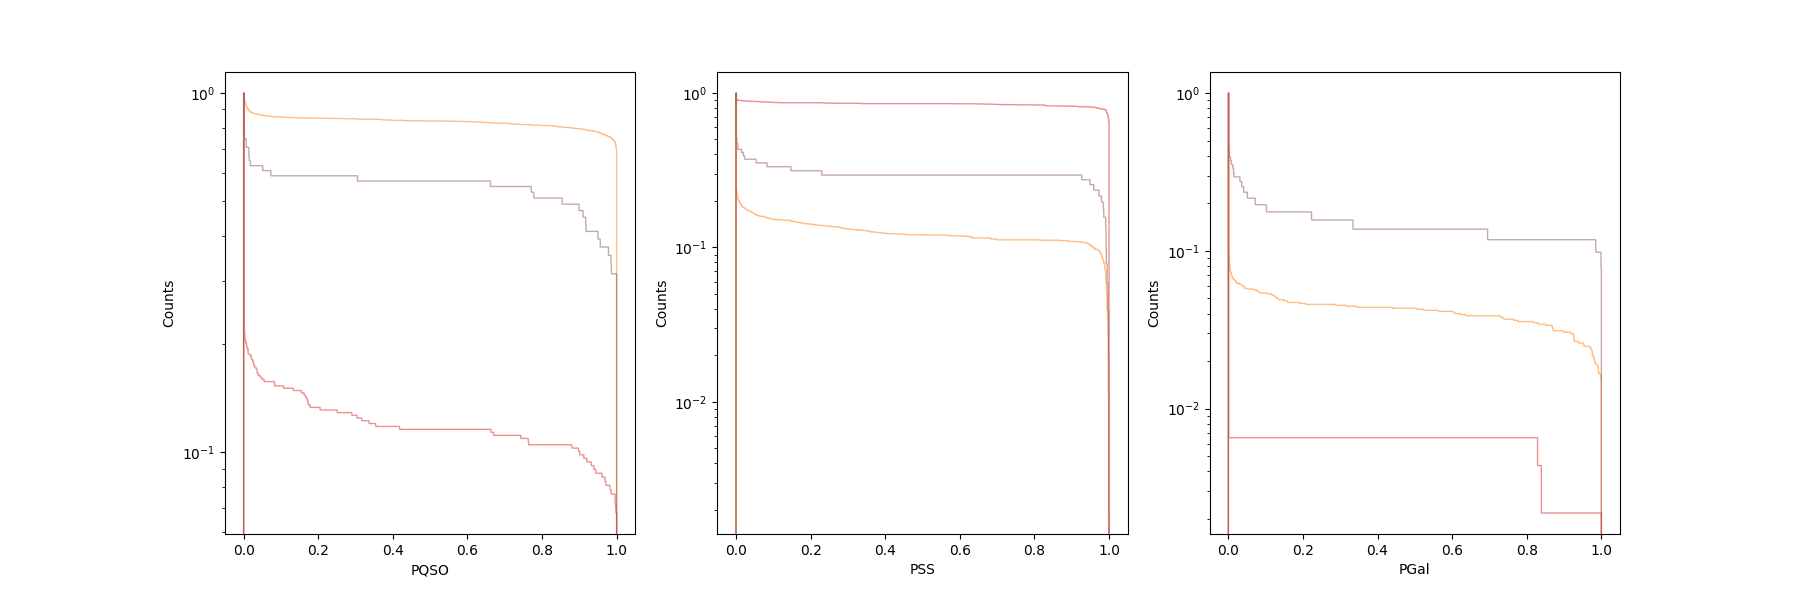

In [8]:
#Reset source selection
rc.tt_sources["sel"]=True

#Define selections for different SIMBAD object groups
sel_AGN = rc.tt_sources["ogrp_simbad"]=="AGN"
sel_star = np.array((rc.tt_sources["ogrp_simbad"]=="Star*")+(rc.tt_sources["ogrp_simbad"]=="S*"), dtype=bool)
sel_gal = rc.tt_sources["ogrp_simbad"]=="GAL"
sels_ogrp = [sel_AGN,sel_star,sel_gal]

#GAIA variables to plot
gaia_vars = ["PQSO","PSS","PGal"]

#Define figure parameters and loop to do plots
fig, axs = plt.subplots(1, 3, figsize=(18, 6),num="Cummulative probabilities of object groups")
hist_bins = np.linspace(0.0,1.0,1001)
hist_dens = True
axs = np.array(axs).flatten()
panel = 0
cumulative = -1
for var in gaia_vars:
    for sel in sels_ogrp:
        _ = vvis.plot_table_hist(rc.tt_sources[sel], var, ax=axs[panel], density= hist_dens, bins=hist_bins,cumulative= cumulative )
    panel+=1
    
#Print out figure labels
print("SIMBAD assoc: orange:AGN; red:Star; brown:Galaxy")

### Hertzsprung russel diagram

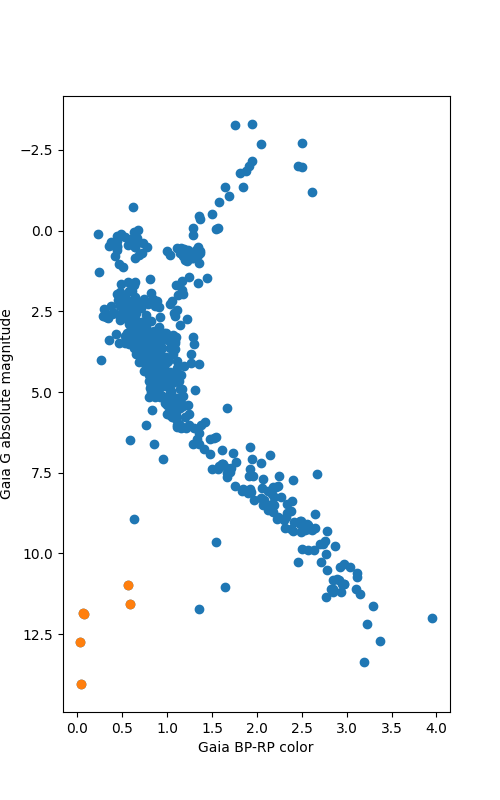

In [9]:
tt_HR = rc.tt_sources[rc.tt_sources["Gmag_abs"]>-10]
fig, axs = plt.subplots(1, 1, figsize=(5, 8),num="HR", clear=True)
axs = np.array(axs).flatten()
axs[0].invert_yaxis()
axs[0].plot(tt_HR["BP-RP"],tt_HR["Gmag_abs"],"o")
#axs[0].invert_yaxis()
axs[0].plot(tt_HR["BP-RP"][tt_HR["ogrp_gaiadr3"]=="WD*"],tt_HR["Gmag_abs"][tt_HR["ogrp_gaiadr3"]=="WD*"],"o")
#axs[0].invert_yaxis()
axs[0].set_xlabel("Gaia BP-RP color")
axs[0].set_ylabel("Gaia G absolute magnitude")
plt.show()

In [10]:
from astroquery.simbad import Simbad

testSimbad = Simbad()

#testSimbad.list_votable_fields()
all_vo_fields = ["biblio","cel","cl.g","coo(opt)","coo_bibcode","coo_err_angle","coo_err_maja","coo_err_mina","coo_qual","coo_wavelength","coordinates","dec(opt)","dec_prec","diameter","dim","dim_angle","dim_bibcode","dim_incl","dim_majaxis","dim_minaxis","dim_qual","dim_wavelength","dimensions","distance","distance_result","einstein","fe_h","flux(filtername)","flux_bibcode(filtername)","flux_error(filtername)","flux_name(filtername)","flux_qual(filtername)","flux_system(filtername)","flux_unit(filtername)","fluxdata(filtername)","gcrv","gen","gj","hbet","hbet1","hgam","id(opt)","ids","iras","irc","iso","iue","jp11","link_bibcode","main_id","measurements","membership","mesplx","mespm","mk","morphtype","mt","mt_bibcode","mt_qual","otype","otype(opt)","otypes","parallax","plx","plx_bibcode","plx_error","plx_prec","plx_qual","pm","pm_bibcode","pm_err_angle","pm_err_maja","pm_err_mina","pm_qual","pmdec","pmdec_prec","pmra","pmra_prec","pos","posa","propermotions","ra(opt)","ra_prec","rot","rv_value","rvz_bibcode","rvz_error","rvz_qual","rvz_radvel","rvz_type","rvz_wavelength","sao","sp","sp_bibcode","sp_nature","sp_qual","sptype","td1","typed_id","ubv","uvby","uvby1","v*","velocity","xmm","z_value"]

#for vo_field in all_vo_fields:
#    print("*",vo_field)
#    testSimbad.get_field_description(vo_field)